In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [7]:
# importing the data
df = pd.read_csv('final_df.csv',infer_datetime_format=True,
                    index_col=['datetime'])
df.index = pd.to_datetime(df.index)
print(df.shape)
df.head(3)

(2007305, 8)


,global_active_power,voltage,year,quarter,month,day,temperature,weekday
datetime,,,,,,,,
2007-01-01 00:00:00,2.5800,241.9700,2007,1,1,1,13.3000,1
2007-01-01 00:01:00,2.5520,241.7500,2007,1,1,1,13.3000,1
2007-01-01 00:02:00,2.5500,241.6400,2007,1,1,1,13.3000,1


In [8]:
# converting to float32 as it takes up less memory and operations can be faster 
data = df.global_active_power.values
data = data.astype('float32')

# reshaping
data = np.reshape(data, (-1, 1))
minmax = MinMaxScaler(feature_range=(0, 1))

# need to scale the data on training set, then transform the unseen data using this
# otherwise the model would overfit and achieve better results, which is not ideal for
# real world use of the model
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size

# train_test_split
train, test = data[0:train_size,:], data[train_size:len(data),:]

# scaling
train = minmax.fit_transform(train)
test = minmax.transform(test)

In [9]:
# need to create an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    X, y = list(), list()
    for i in range(len(dataset)-look_back-1):            
        a = (dataset[i:(i+look_back), 0])
        X.append(a)
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

In [10]:
# reshaping into X=t and y=t+1
look_back = 100
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1605743, 100) (401360, 100) (1605743,) (401360,)


In [11]:
# reshaping input into [samples, time_steps, features] format
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, X_test.shape)

(1605743, 1, 100) (401360, 1, 100)


In [12]:
# time for modelling
model = Sequential()
model.add(LSTM(100, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 1605743 samples, validate on 401360 samples
Epoch 1/20
1605743/1605743 [==============================] - 222s 138us/step - loss: 0.0010 - val_loss: 4.2911e-04
Epoch 2/20
1605743/1605743 [==============================] - 219s 136us/step - loss: 7.2881e-04 - val_loss: 4.6414e-04
Epoch 3/20
1605743/1605743 [==============================] - 220s 137us/step - loss: 6.7825e-04 - val_loss: 4.3932e-04
Epoch 4/20
1605743/1605743 [==============================] - 221s 137us/step - loss: 6.5700e-04 - val_loss: 4.5522e-04
Epoch 5/20
1605743/1605743 [==============================] - 220s 137us/step - loss: 6.4050e-04 - val_loss: 4.4476e-04
Epoch 6/20
1605743/1605743 [==============================] - 220s 137us/step - loss: 6.2940e-04 - val_loss: 4.3206e-04
Epoch 7/20
1605743/1605743 [==============================] - 221s 137us/step - loss: 6.2022e-04 - val_loss: 4.4769e-04
Epoch 8/20
1605743/1605743 [==============================] - 220s 137us/step - loss: 6.1042e-04 - val_loss: 4.

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = minmax.inverse_transform(train_predict)
y_train = minmax.inverse_transform([y_train])
test_predict = minmax.inverse_transform(test_predict)
y_test = minmax.inverse_transform([y_test])

print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.20987012931663987
Train Root Mean Squared Error: 0.30189010249364967
Test Mean Absolute Error: 0.189517954561053
Test Root Mean Squared Error: 0.2597281292076344


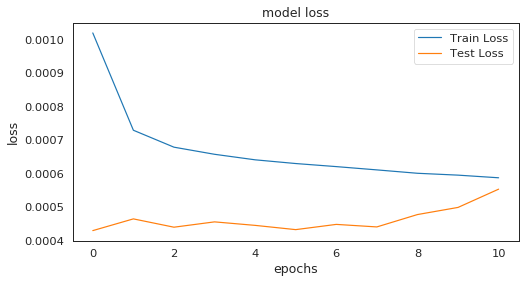

In [14]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

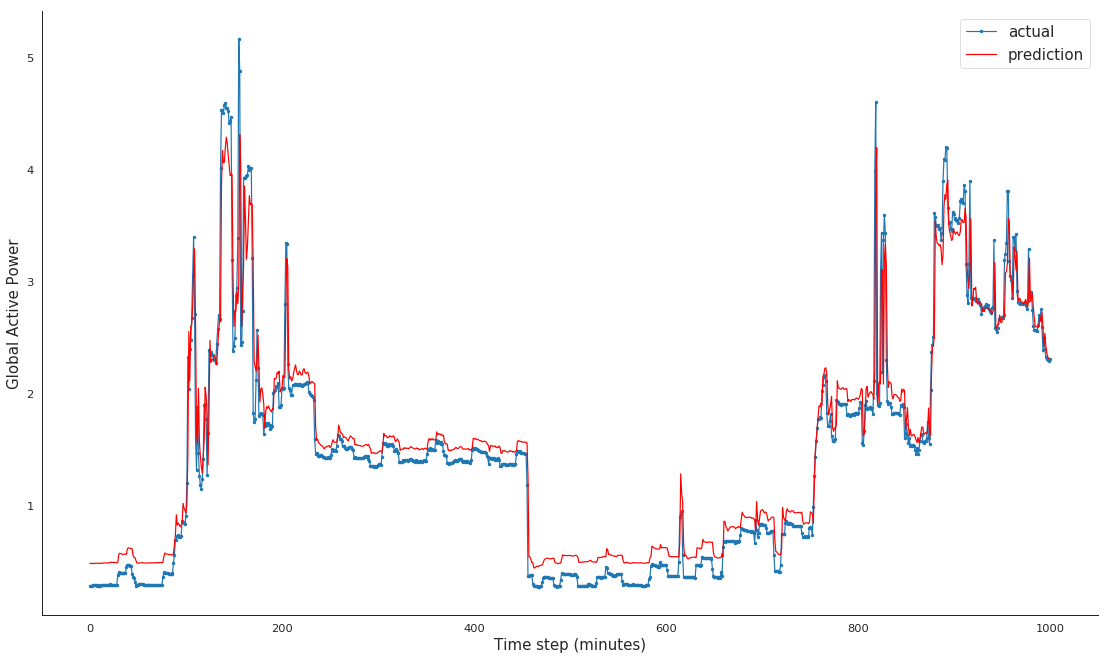

In [15]:
aa=[x for x in range(1000)]
plt.figure(figsize=(16,9))
plt.plot(aa, y_test[0][:1000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:1000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Active Power (kWh)', size=15)
plt.xlabel('Time step (minutes)', size=15)
plt.legend(fontsize=15)
plt.show();

In [17]:
# saving the model
from keras.models import load_model

model.save('lstm_model_1.h5')